In [1]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch 1.13.1+cpu
torchvision 0.14.1+cpu


In [2]:
IMG_SIZE = 480
THRESHOLD = 0.95

In [3]:
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


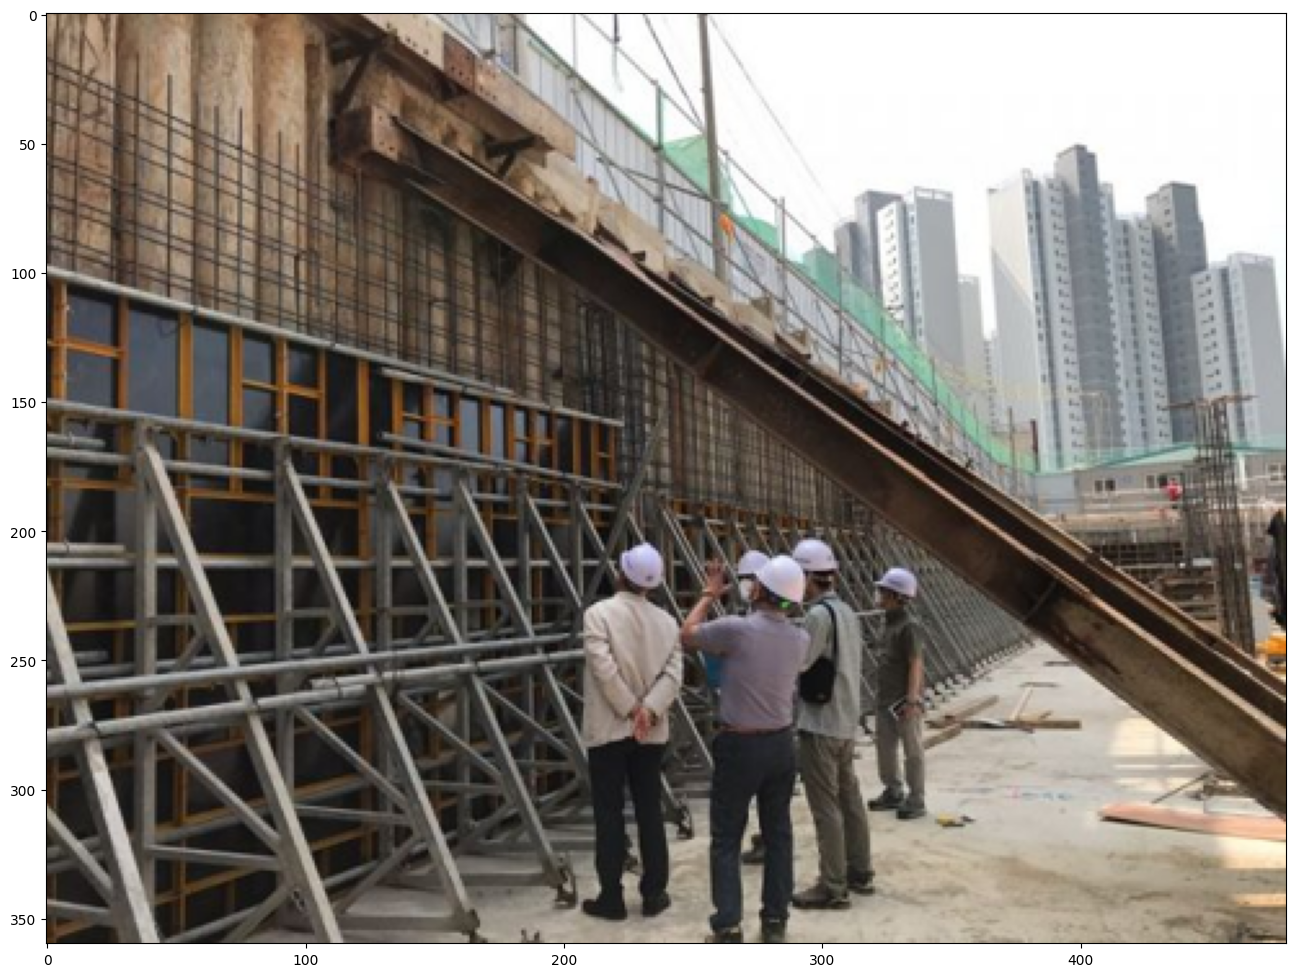

In [4]:
img = Image.open(r'E:\GithubProjects\KagglePractice\HelmetDetection\TestImage\test.jpg')
img = img.resize((IMG_SIZE, int(img.height * IMG_SIZE / img.width)))

plt.figure(figsize=(16, 16))
plt.imshow(img)

In [5]:
trf = T.Compose([
    T.ToTensor()
])

input_img = trf(img)

print(input_img.shape)

torch.Size([3, 360, 480])


In [6]:
out = model([input_img])[0]

print(out.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


Colours  
https://matplotlib.org/stable/gallery/color/named_colors.html  

4


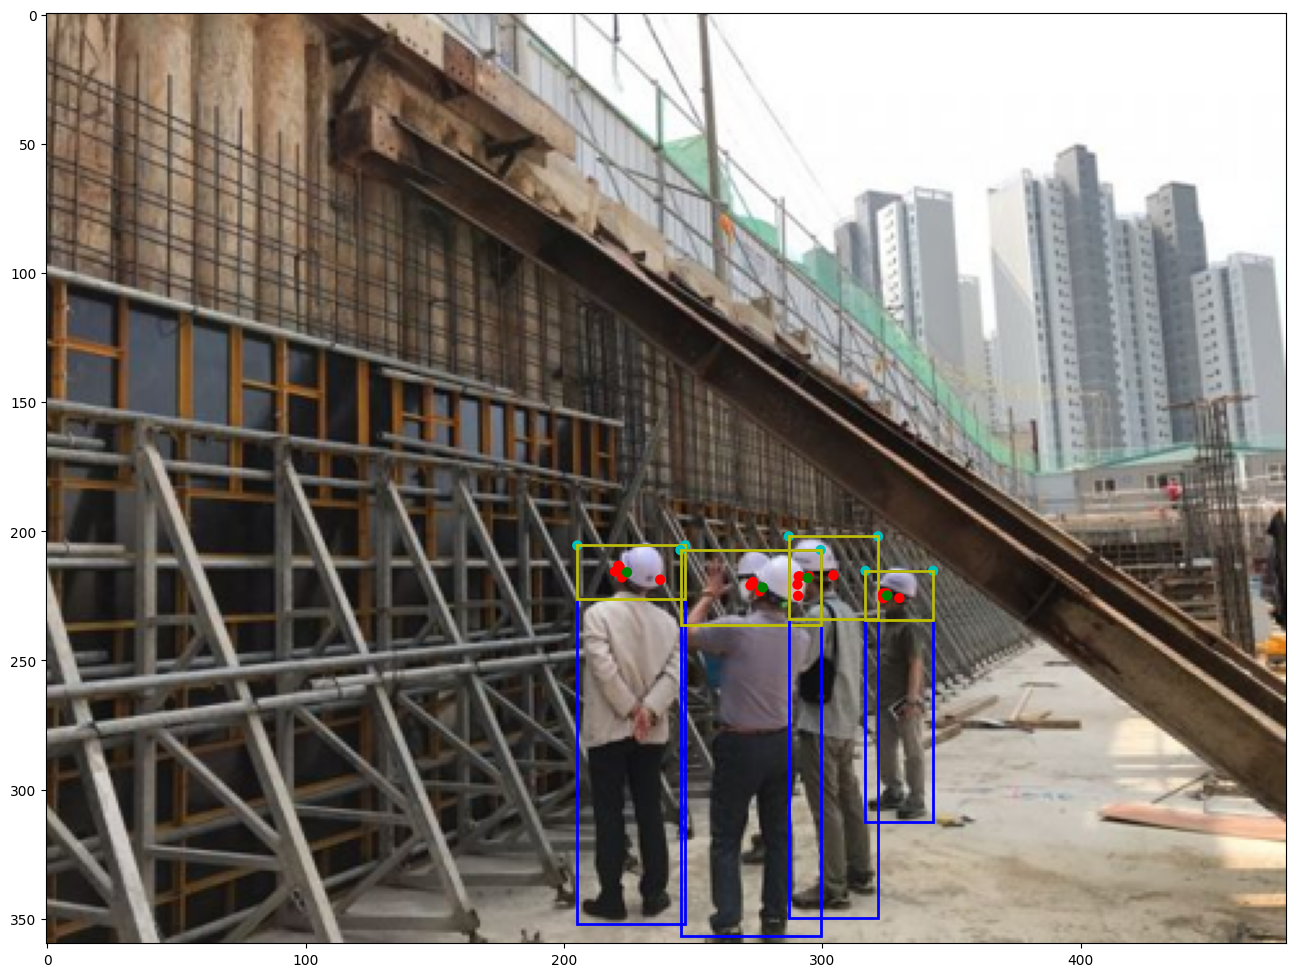

In [8]:
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO
]

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img)

HeadList = []

for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
	score = score.detach().numpy()

	if score < THRESHOLD:
		continue

	box = box.detach().numpy()
	keypoints = keypoints.detach().numpy()[:, :2]

	rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
	ax.add_patch(rect)
	x0, y0, x1, y1 = box
	# x0, y0 : 좌측 상단
	# x1, y1 : 우측 하단
	ax.add_patch(patches.Circle((x0, y0), radius=2, facecolor='c'))
	ax.add_patch(patches.Circle((x1, y0), radius=2, facecolor='c'))

	# 머리 쪽만 확인
	HeadPointLocs = []
	for k in keypoints[:5]:
		circle = patches.Circle((k[0], k[1]), radius=2, facecolor='r')
		HeadPointLocs.append((k[0], k[1]))
		ax.add_patch(circle)
	
	# 머리 키 포인트들의 중심점을 구합니다
	HeadMiddlePoint = (sum(map(lambda x : x[0], HeadPointLocs)) / len(HeadPointLocs),
					   sum(map(lambda x : x[1], HeadPointLocs)) / len(HeadPointLocs))
	ax.add_patch(patches.Circle(HeadMiddlePoint, radius=2, facecolor='g'))

	# 머리 부분을 구합니다
	# 구하는 방식은 다음과 같습니다
	# (박스의 가장 위 y) - (머리 중심점 y) = 0.5 * height

	rect = patches.Rectangle((x0, y0), x1 - x0, (HeadMiddlePoint[1] - y0) * 2, linewidth=2, edgecolor='y', facecolor='none')
	ax.add_patch(rect)
	HeadList.append((
					np.asarray(img)[int(y0):int(y0 + (HeadMiddlePoint[1] - y0) * 2),int(x0) : int(x1)],
					(int(x0), int(y0)),
					(int(x1), int(y0 + (HeadMiddlePoint[1] - y0) * 2))
					))
print(len(HeadList))

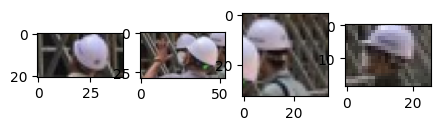

In [9]:
for i, img in enumerate(HeadList):
	plt.subplot(1, 5, i + 1)
	plt.imshow(img[0])
plt.show()

In [10]:
from cv2 import resize

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


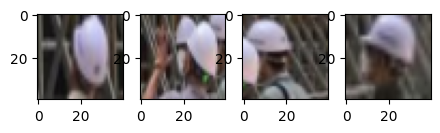

In [11]:
for i, img in enumerate(HeadList):
	plt.subplot(1, 5, i + 1)
	plt.imshow(resize(img[0], dsize=(40, 40)))
	print(type(img[0]))
plt.show()

음.. 뭔가 별로인 거 같다.  
조금만 보강해보자  

In [12]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

pytorch 1.13.1+cpu
torchvision 0.14.1+cpu


In [13]:
IMG_SIZE = 480

COLORS = np.array([
    (0, 0, 0),       # 0=background
    (128, 0, 0),     # 1=aeroplane
    (0, 128, 0),     # 2=bicycle
    (128, 128, 0),   # 3=bird
    (0, 0, 128),     # 4=boat
    (128, 0, 128),   # 5=bottle
    (0, 128, 128),   # 6=bus
    (128, 128, 128), # 7=car
    (255, 255, 127), # 8=cat
    (192, 0, 0),     # 9=chair
    (64, 128, 0),    # 10=cow
    (192, 128, 0),   # 11=dining table
    (64, 0, 128),    # 12=dog
    (192, 0, 128),   # 13=horse
    (64, 128, 128),  # 14=motorbike
    (255, 255, 255), # 15=person
    (0, 64, 0),      # 16=potted plant
    (128, 64, 0),    # 17=sheep
    (0, 192, 0),     # 18=sofa
    (128, 192, 0),   # 19=train
    (0, 64, 128)     # 20=tv/monitor
])

In [14]:
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

c:\Users\th070\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


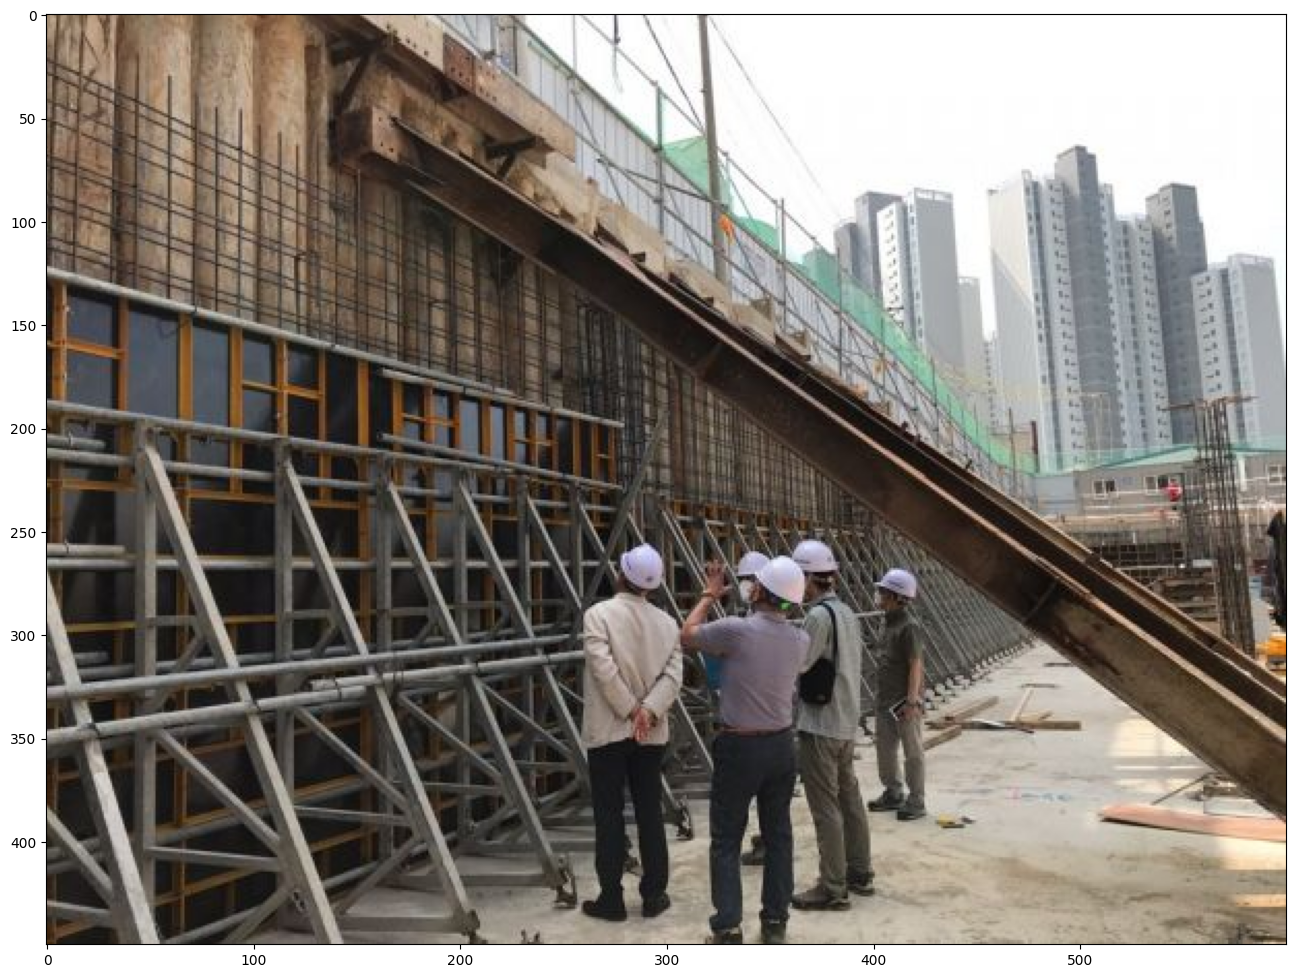

In [15]:
img = Image.open(r'E:\GithubProjects\KagglePractice\HelmetDetection\TestImage\test.jpg')

plt.figure(figsize=(16, 16))
plt.imshow(img)

In [16]:
# T.Compose 는 리스트 안에 있는 작업을 차례차례 수행해줘라 입니다
trf = T.Compose([
    T.Resize(IMG_SIZE), # 이미지의 너비를 IMG_SIZE 로 설정합니다.
#     T.CenterCrop(IMG_SIZE), # 정 사각형으로 만들고 싶을 땐 이걸 씁니다
    T.ToTensor(),  # 이미지를 파이토치 텐서로 변경합니다. 이 때 값은 0, 1 사이 입니다.
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
	# 이미지는 명도, 채도가 전부 다르기 때문에 이를 평균과 표준편차로 설정해줄 필요가 있습니다
	# https://eehoeskrap.tistory.com/463
])

input_img = trf(img).unsqueeze(0)
# 차원을 하나 추가해줍니다
# (3,) -> (1,3)
# https://wikidocs.net/52846

# 추가하는 이유는 모델이 그렇게 설계됐기 때문입니당!
# (아마 여러 이미지를 동시에 예측하려는 이유 때문일 것으로 추정..)

In [17]:
out = deeplab(input_img)['out']

print(out.shape)

torch.Size([1, 21, 480, 640])


In [18]:
out = torch.argmax(out.squeeze(), dim=0)
out = out.detach().cpu().numpy()

print(out.shape)
print(np.unique(out))

(480, 640)
[ 0 15]


In [19]:
def seg_map(img, n_classes=21):
	rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

	for c in range(n_classes):
		idx = img == c

		rgb[idx] = COLORS[c]

	return rgb

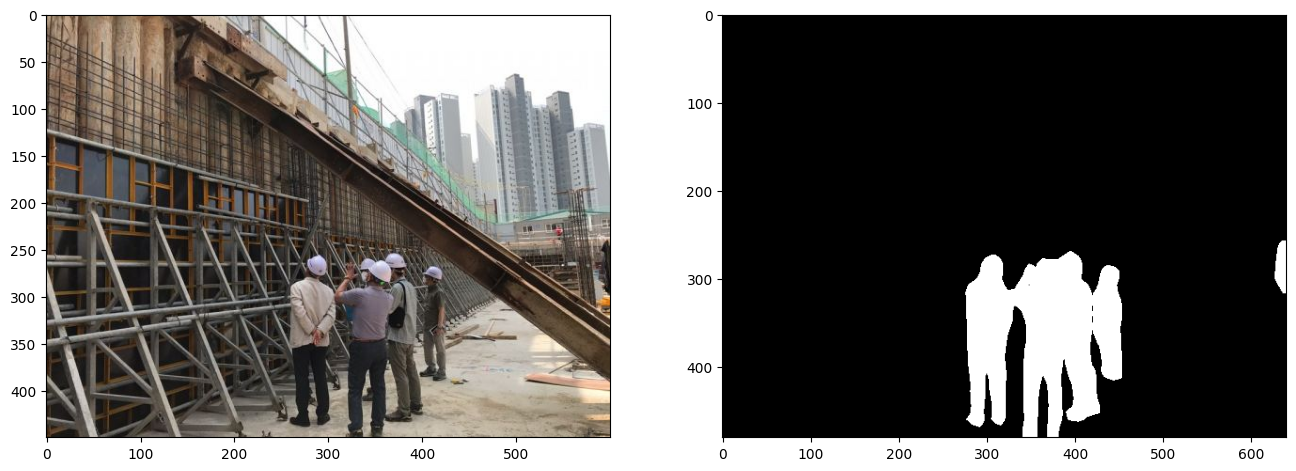

In [20]:
out_seg = seg_map(out)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax[0].imshow(img)
ax[1].imshow(out_seg)

(600, 450)


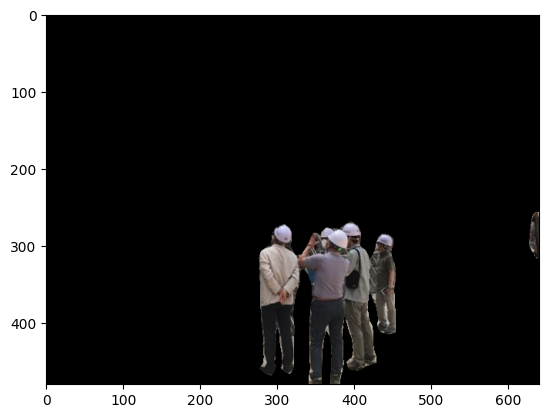

In [54]:
# OriginalRescaledImage = copy.deepcopy(img)
# OriginalRescaledImage = OriginalRescaledImage.resize((640,480))
# OriginalRescaledImage = np.asarray(OriginalRescaledImage)
print(img.size)
ClearImage = img.resize((640, 480)) & out_seg
plt.imshow(ClearImage)

(205, 205) (246, 226)
(245, 207) (299, 236)
(287, 201) (321, 234)
(316, 215) (342, 234)


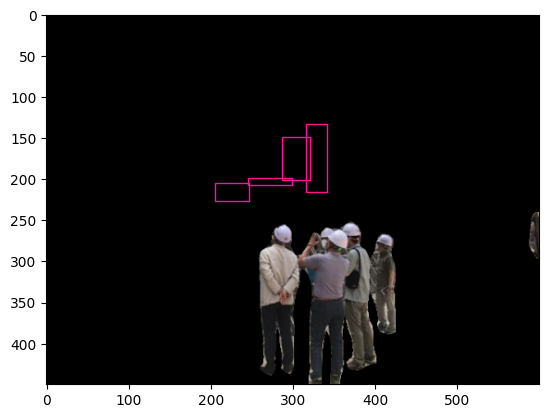

In [72]:
fig, ax = plt.subplots()
plt.imshow(ClearImage)
ClearImage = resize(ClearImage, (640, 480))
for i, data in enumerate(HeadList):
	pos0, pos1 = data[1], data[2]
	print(pos0, pos1)
	# plt.subplot(1, 5, i + 1)
	ax.add_patch(
		patches.Rectangle(
			pos0,                   # (x, y)
			pos1[0] - pos0[0], pos1[1] - pos0[0],                     # width, height
			edgecolor = 'deeppink',
			fill=False,
		))
	# plt.imshow(ClearImage[pos0[1] : pos1[1], pos0[0] : pos1[0]])
# plt.show()

음.. 변경해보겠습니다